# 🎯 Magic Steps — Análise Exploratória dos Dados Crus

Notebook gerado com métricas calculadas diretamente sobre o arquivo original
`BASE DE DADOS PEDE 2024 - DATATHON.xlsx`, **antes** de qualquer pré-processamento.

| Campo | Valor |
|---|---|
| **Alunos** | 860 |
| **Colunas** | 42 |
| **Target** | `Atingiu PV` — Não (747) / Sim (113) → **desbalanceamento 6.6 : 1** |
| **Dados ausentes críticos** | `Inglês` (67 %), `Pedra 20` (62 %), `Pedra 21` (46 %) |

---

## 📑 Índice
1. [Setup & Carregamento](#1-setup--carregamento)
2. [Visão Geral Estrutural](#2-visão-geral-estrutural)
3. [Análise Univariada — Numéricas](#3-análise-univariada--numéricas)
4. [Testes de Normalidade & Outliers](#4-testes-de-normalidade--outliers)
5. [Análise do Target — Desbalanceamento](#5-análise-do-target--desbalanceamento)
6. [Comparação entre Classes — Point-Biserial & Mann-Whitney](#6-comparação-entre-classes--point-biserial--mann-whitney)
7. [Análise Bivariada — Correlações Pearson](#7-análise-bivariada--correlações-pearson)
8. [Variáveis Categóricas — Chi-Square & Cramér V](#8-variáveis-categóricas--chi-square--cramér-v)
9. [Taxa de Atingimento por Categoria](#9-taxa-de-atingimento-por-categoria)
10. [Evolução das Pedras (2020 → 2022)](#10-evolução-das-pedras-2020--2022)
11. [Dados Ausentes — Padrões & Impacto](#11-dados-ausentes--padrões--impacto)
12. [Conclusões & Recomendações para o Pipeline](#12-conclusões--recomendações-para-o-pipeline)


## 1. Setup & Carregamento


In [2]:
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from scipy import stats

# ── estilo ────────────────────────────────────────────
plt.rcParams.update({
    'figure.figsize': (14, 5), 'figure.dpi': 110,
    'axes.titlesize': 13, 'axes.labelsize': 10,
    'xtick.labelsize': 8.5, 'ytick.labelsize': 8.5,
    'legend.fontsize': 8.5, 'axes.grid': True, 'grid.alpha': 0.25,
})
sns.set_style('whitegrid')

PAL = {'0': '#e74c3c', '1': '#27ae60'}   # vermelho / verde
PAL_LIST = [PAL['0'], PAL['1']]

# ── carregamento ──────────────────────────────────────
DATA = Path(r'/content/BASE DE DADOS PEDE 2024 - DATATHON.xlsx')
df = pd.read_excel(DATA)

# target binário
df['_target'] = (df['Atingiu PV'].str.strip().str.lower() == 'sim').astype(int)

# grupos de colunas
NUM     = ['Fase','Idade 22','Ano ingresso','INDE 22','Cg','Cf','Ct','Nº Av',
           'IAA','IEG','IPS','IDA','Matem','Portug','Inglês','IPV','IAN','Defas']
SCORES  = ['INDE 22','IAA','IEG','IPS','IDA','IPV','IAN']
NOTAS   = ['Matem','Portug','Inglês']
CAD     = ['Cg','Cf','Ct']
CAT     = ['Gênero','Instituição de ensino','Pedra 22','Turma',
           'Rec Av1','Rec Psicologia','Fase ideal']

print(f'✅ Dados carregados — {df.shape[0]} alunos × {df.shape[1]} colunas')
print(f'   Target → Não: {(df["_target"]==0).sum()}  |  Sim: {(df["_target"]==1).sum()}')


✅ Dados carregados — 860 alunos × 43 colunas
   Target → Não: 747  |  Sim: 113


## 2. Visão Geral Estrutural


In [3]:
# ── 2a. metadados por coluna ──────────────────────────
meta = pd.DataFrame({
    'dtype':    df.dtypes.astype(str),
    'não-nulo': df.notna().sum(),
    'nulos':    df.isna().sum(),
    'nulo_%':   (df.isna().mean()*100).round(1),
    'únicos':   df.nunique(),
})
meta.loc[meta['nulos']>0, 'nulo_%'] = meta.loc[meta['nulos']>0, 'nulo_%'].apply(
    lambda x: f'{x:.1f} ⚠️'
)
meta


,dtype,não-nulo,nulos,nulo_%,únicos
RA,object,860,0,0.0,860
Fase,int64,860,0,0.0,8
Turma,object,860,0,0.0,24
Nome,object,860,0,0.0,860
Ano nasc,int64,860,0,0.0,15
Idade 22,int64,860,0,0.0,15
Gênero,object,860,0,0.0,2
Ano ingresso,int64,860,0,0.0,7
Instituição de ensino,object,860,0,0.0,3
Pedra 20,object,323,537,62.4 ⚠️,4


In [4]:
df.head(6)


,RA,Fase,Turma,Nome,Ano nasc,Idade 22,Gênero,Ano ingresso,Instituição de ensino,Pedra 20,...,Indicado,Atingiu PV,IPV,IAN,Fase ideal,Defas,Destaque IEG,Destaque IDA,Destaque IPV,_target
0,RA-1,7,A,Aluno-1,2003,19,Menina,2016,Escola Pública,Ametista,...,Sim,Não,7.278,5.0,Fase 8 (Universitários),-1,Melhorar: Melhorar a sua entrega de lições de ...,Melhorar: Empenhar-se mais nas aulas e avaliaç...,Melhorar: Integrar-se mais aos Princípios Pass...,0
1,RA-2,7,A,Aluno-2,2005,17,Menina,2017,Rede Decisão,Ametista,...,Não,Não,6.778,10.0,Fase 7 (3º EM),0,Melhorar: Melhorar a sua entrega de lições de ...,Melhorar: Empenhar-se mais nas aulas e avaliaç...,Melhorar: Integrar-se mais aos Princípios Pass...,0
2,RA-3,7,A,Aluno-3,2005,17,Menina,2016,Rede Decisão,Ametista,...,Não,Não,7.556,10.0,Fase 7 (3º EM),0,Destaque: A sua boa entrega das lições de casa.,Melhorar: Empenhar-se mais nas aulas e avaliaç...,Destaque: A sua boa integração aos Princípios ...,0
3,RA-4,7,A,Aluno-4,2005,17,Menino,2017,Rede Decisão,Ametista,...,Não,Não,5.278,10.0,Fase 7 (3º EM),0,Melhorar: Melhorar a sua entrega de lições de ...,Melhorar: Empenhar-se mais nas aulas e avaliaç...,Melhorar: Integrar-se mais aos Princípios Pass...,0
4,RA-5,7,A,Aluno-5,2005,17,Menina,2016,Rede Decisão,Ametista,...,Não,Não,7.389,10.0,Fase 7 (3º EM),0,Destaque: A sua boa entrega das lições de casa.,Melhorar: Empenhar-se mais nas aulas e avaliaç...,Melhorar: Integrar-se mais aos Princípios Pass...,0
5,RA-6,7,A,Aluno-6,2004,18,Menina,2021,Escola Pública,NaN,...,Sim,Não,7.222,5.0,Fase 8 (Universitários),-1,Melhorar: Melhorar a sua entrega de lições de ...,Melhorar: Empenhar-se mais nas aulas e avaliaç...,Melhorar: Integrar-se mais aos Princípios Pass...,0


## 3. Análise Univariada — Numéricas

Histogramas sobrepostos por classe + estatísticas centrais e de dispersão.


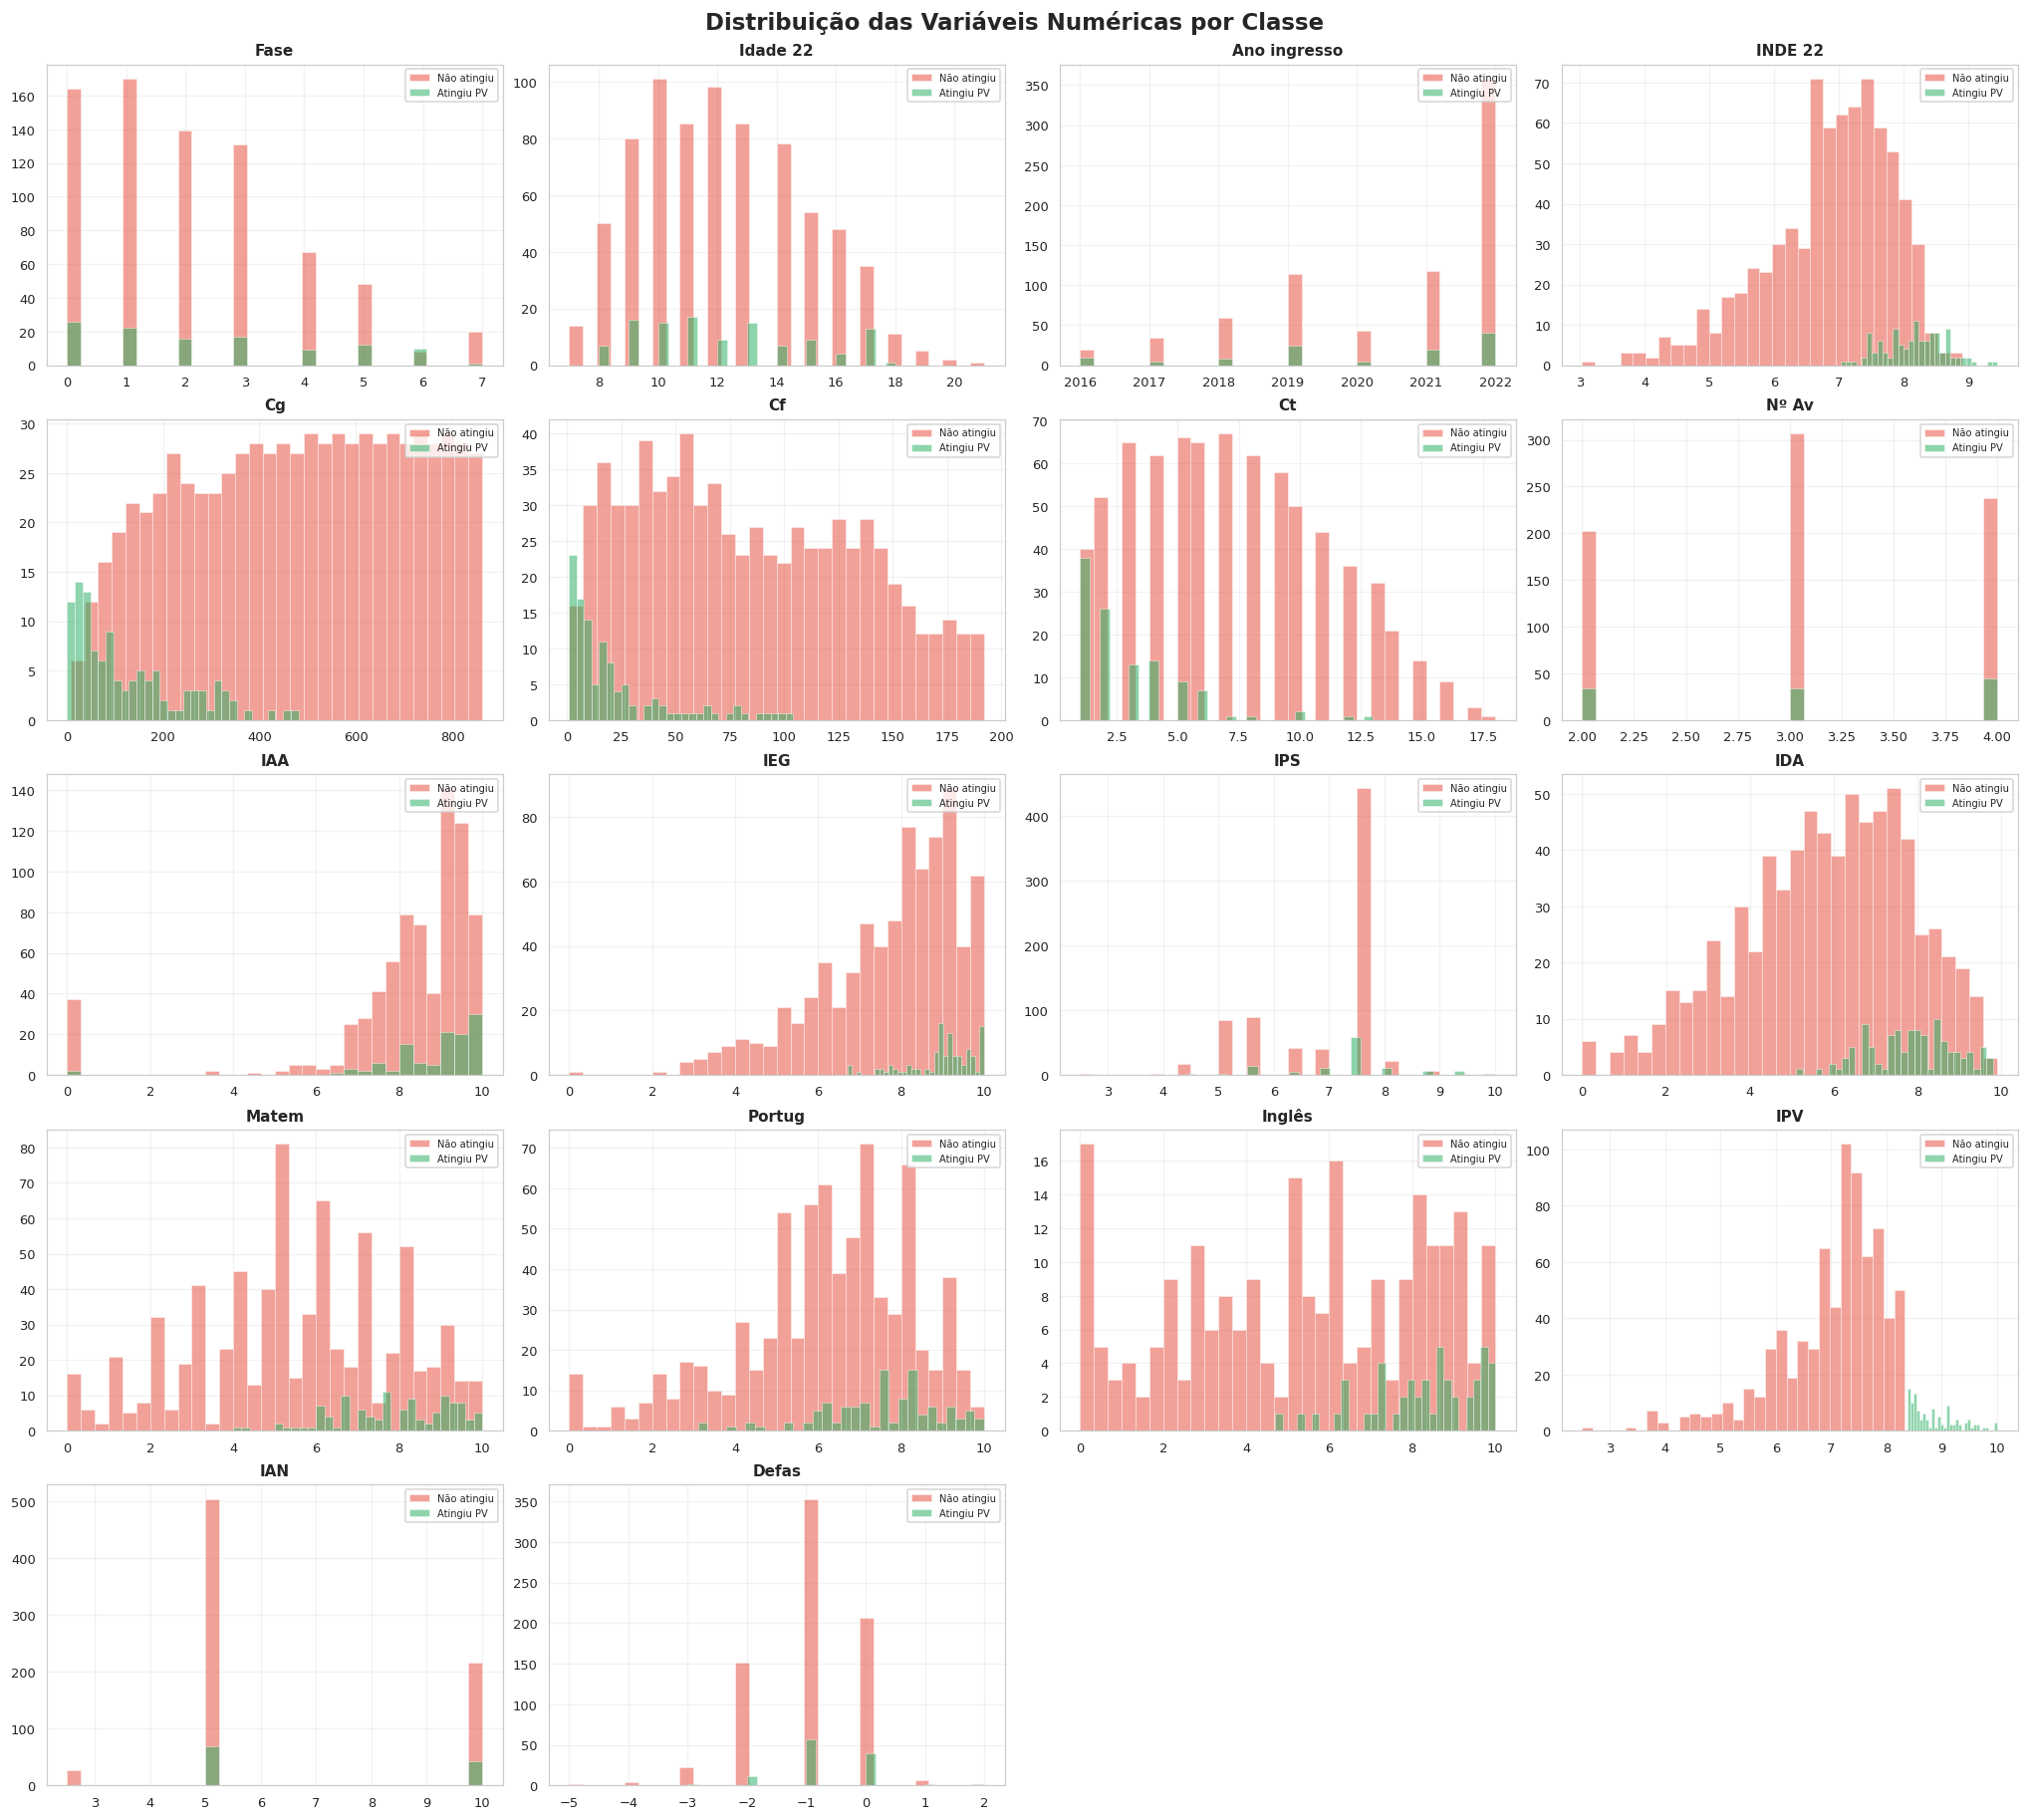

In [5]:
# ── 3a. histogramas por classe ────────────────────────
n = len(NUM)
NC = 4
NR = -(-n // NC)

fig, axes = plt.subplots(NR, NC, figsize=(NC*4.6, NR*3.3), constrained_layout=True)
axes = axes.flatten()

for i, col in enumerate(NUM):
    ax = axes[i]
    for label, color in zip([0,1], PAL_LIST):
        s = df.loc[df['_target']==label, col].dropna()
        ax.hist(s, bins=30, alpha=0.52, color=color,
                label=('Não atingiu' if label==0 else 'Atingiu PV'),
                edgecolor='white', linewidth=0.5)
    ax.set_title(col, fontsize=10, fontweight='bold')
    ax.legend(fontsize=6.5, loc='upper right')

for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

fig.suptitle('Distribuição das Variáveis Numéricas por Classe', fontsize=15, fontweight='bold')
plt.show()


In [6]:
# ── 3b. tabela descritiva completa ────────────────────
desc = df[NUM].describe().T
desc.columns = [c.title() for c in desc.columns]
desc['Skewness'] = df[NUM].skew().round(3)
desc['Kurtose']  = df[NUM].kurtosis().round(3)
desc[['Mean','Std','Min','Max']] = desc[['Mean','Std','Min','Max']].round(3)
desc


,Count,Mean,Std,Min,25%,50%,75%,Max,Skewness,Kurtose
Fase,860.0,2.099,1.789,0.000,1.0000,2.000,3.00000,7.000,0.739,-0.080
Idade 22,860.0,12.138,2.772,7.000,10.0000,12.000,14.00000,21.000,0.335,-0.606
Ano ingresso,860.0,2020.497,1.790,2016.000,2019.0000,2021.000,2022.00000,2022.000,-0.913,-0.364
INDE 22,860.0,7.036,1.018,3.032,6.4855,7.197,7.75125,9.442,-0.742,0.514
Cg,860.0,430.516,248.433,1.000,215.7500,430.500,645.25000,862.000,0.000,-1.199
Cf,860.0,75.520,52.313,1.000,30.0000,67.000,118.00000,192.000,0.402,-0.967
Ct,860.0,6.599,3.976,1.000,3.0000,6.000,9.00000,18.000,0.443,-0.683
Nº Av,860.0,3.055,0.775,2.000,2.0000,3.000,4.00000,4.000,-0.095,-1.330
IAA,860.0,8.274,2.065,0.000,7.9000,8.800,9.50000,10.000,-2.906,9.014
IEG,860.0,7.891,1.638,0.000,7.0000,8.300,9.10000,10.000,-1.098,0.962


## 4. Testes de Normalidade & Outliers

- **Shapiro-Wilk** (H₀ = distribuição normal) → p < 0.05 rejeita normalidade.
- **Outliers pelo método IQR** → valores fora de [Q1 − 1.5·IQR, Q3 + 1.5·IQR].
- **Kurtose (Fisher/excess)** — valor elevado indica caudas pesadas.


In [7]:
# ── 4a. tabela normalidade + outliers ──────────────────
from scipy import stats as _stats

rows_norm = []
for col in NUM:
    s = df[col].dropna()
    sk = _stats.skew(s)
    ku = _stats.kurtosis(s)                          # Fisher (excess)
    _, p_sw = _stats.shapiro(s)
    q1, q3  = s.quantile(0.25), s.quantile(0.75)
    iqr     = q3 - q1
    n_out   = int(((s < q1 - 1.5*iqr) | (s > q3 + 1.5*iqr)).sum())
    rows_norm.append([col, round(p_sw, 6), p_sw < 0.05,
                      round(ku, 4), n_out, int(df[col].isna().sum())])

df_norm = pd.DataFrame(rows_norm,
    columns=['Feature','Shapiro p-valor','Rejeita H₀',
             'Kurtose (excess)','Outliers IQR','Nulos'])
df_norm['% Outliers'] = (df_norm['Outliers IQR'] / len(df) * 100).round(1)
df_norm = df_norm.sort_values('Outliers IQR', ascending=False)
df_norm


,Feature,Shapiro p-valor,Rejeita H₀,Kurtose (excess),Outliers IQR,Nulos,% Outliers
8,IAA,0.0,True,8.9546,49,0,5.7
15,IPV,0.0,True,1.1235,36,0,4.2
17,Defas,0.0,True,1.0671,31,0,3.6
10,IPS,0.0,True,0.0202,30,0,3.5
9,IEG,0.0,True,0.9492,26,0,3.0
13,Portug,0.0,True,0.4505,22,2,2.6
3,INDE 22,0.0,True,0.5044,21,0,2.4
0,Fase,0.0,True,-0.0864,21,0,2.4
11,IDA,0.0,True,-0.2141,6,0,0.7
1,Idade 22,0.0,True,-0.6091,1,0,0.1


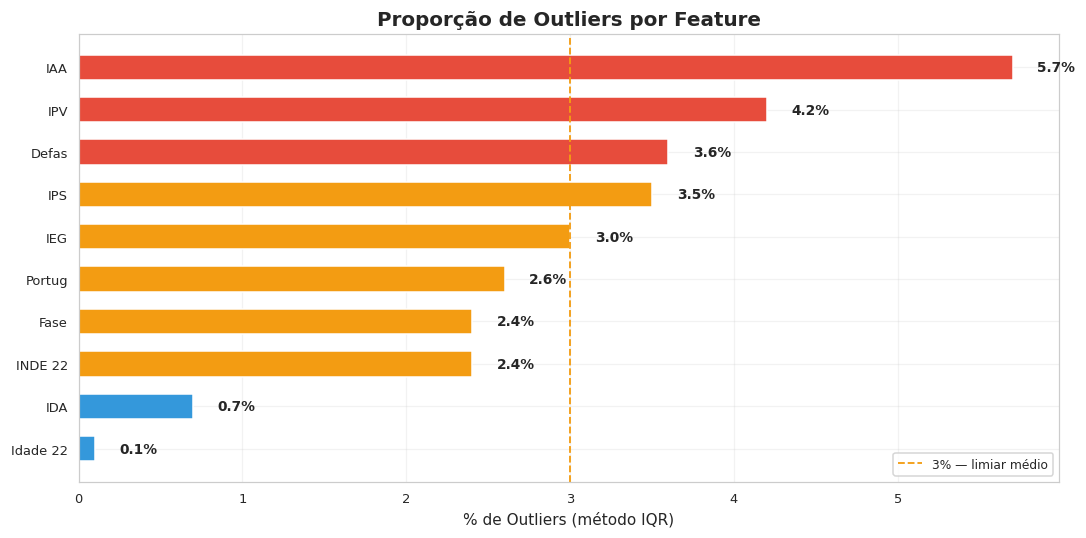

In [8]:
# ── 4b. gráfico outliers IQR ──────────────────────────
fig, ax = plt.subplots(figsize=(10, 5))

out_data = df_norm[df_norm['Outliers IQR'] > 0].sort_values('Outliers IQR', ascending=True)
colors = ['#e74c3c' if v > 30 else '#f39c12' if v > 10 else '#3498db'
          for v in out_data['Outliers IQR']]

bars = ax.barh(out_data['Feature'], out_data['% Outliers'], color=colors, edgecolor='white', height=0.6)
for bar in bars:
    w = bar.get_width()
    ax.text(w + 0.15, bar.get_y() + bar.get_height()/2, f'{w:.1f}%',
            va='center', fontsize=9, fontweight='bold')

ax.axvline(3, color='#f39c12', ls='--', lw=1.2, label='3% — limiar médio')
ax.set_xlabel('% de Outliers (método IQR)')
ax.set_title('Proporção de Outliers por Feature', fontweight='bold')
ax.legend(fontsize=8)
plt.tight_layout()
plt.show()


## 5. Análise do Target — Desbalanceamento

| Classe | Quantidade | Proporção |
|---|---|---|
| Não atingiu PV | 747 | 86.9 % |
| Atingiu PV | 113 | 13.1 % |

**Razão majoridade / minoria = 6.6 : 1** — justifica a estratégia de oversampling sintético no `preprocessing.py`.


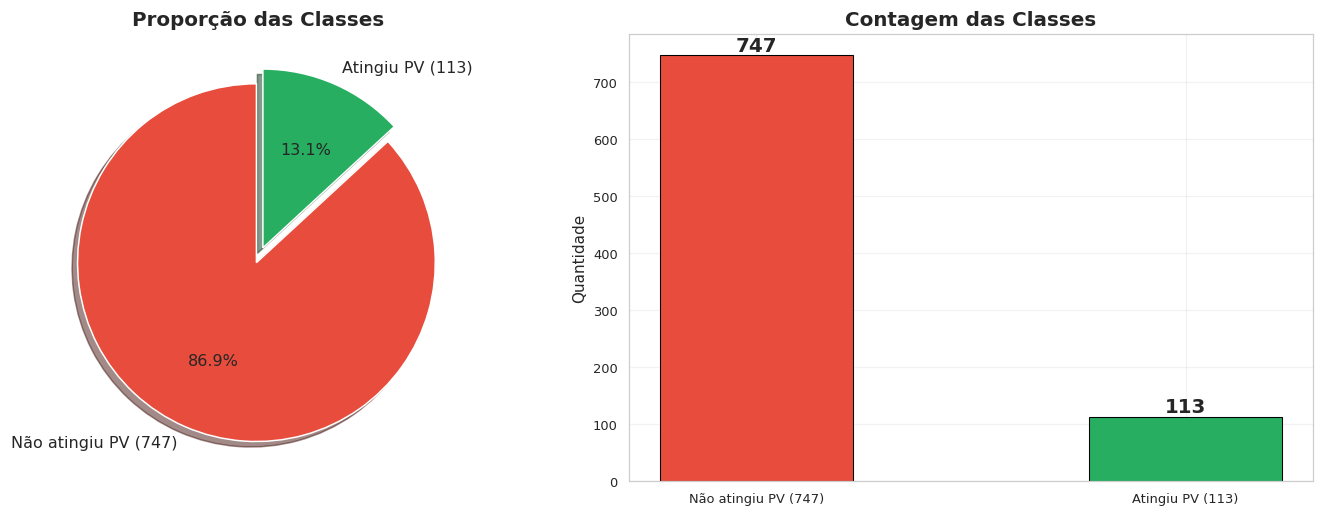

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4.8))

# pie
labels = ['Não atingiu PV (747)', 'Atingiu PV (113)']
ax1.pie([747, 113], labels=labels, colors=PAL_LIST,
        autopct=lambda p: f'{p:.1f}%', startangle=90,
        explode=(0.03, 0.06), textprops={'fontsize': 10.5},
        shadow=True)
ax1.set_title('Proporção das Classes', fontweight='bold')

# bar
bars = ax2.bar(labels, [747, 113], color=PAL_LIST, edgecolor='black',
               linewidth=0.7, width=0.45)
for bar in bars:
    ax2.text(bar.get_x()+bar.get_width()/2, bar.get_height()+8,
             f'{int(bar.get_height()):,}', ha='center', fontsize=13, fontweight='bold')
ax2.set_title('Contagem das Classes', fontweight='bold')
ax2.set_ylabel('Quantidade')
ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x,_: f'{int(x):,}'))
plt.tight_layout()
plt.show()


## 6. Comparação entre Classes — Point-Biserial & Mann-Whitney

| Métrica | O que mede | Quando usar |
|---|---|---|
| **Point-Biserial (r)** | Correlação linear entre variável contínua e binária | Sempre — mede associação |
| **Mann-Whitney U** | Se as distribuições das duas classes são diferentes (não-parametric) | Quando normalidade é rejeitada (aqui: sempre) |
| **Rank-Biserial r** | Effect size do Mann-Whitney. \|r\| > 0.1 pequeno, > 0.3 médio, > 0.5 grande | Quantifica *quão* diferentes são as classes |


In [10]:
# ── 6a. tabela combinada — Point-Biserial + Mann-Whitney ──
from scipy import stats as _stats

rows_comp = []
for col in NUM:
    mask = df[col].notna()
    # point-biserial
    pb_r, pb_p = _stats.pointbiserialr(df.loc[mask, '_target'], df.loc[mask, col])

    # Mann-Whitney U
    g0 = df.loc[df['_target'] == 0, col].dropna()
    g1 = df.loc[df['_target'] == 1, col].dropna()
    U, mw_p = _stats.mannwhitneyu(g0, g1, alternative='two-sided')

    # rank-biserial r (effect size para MW)
    n0, n1 = len(g0), len(g1)
    rb_r   = 1 - (2 * U) / (n0 * n1)

    rows_comp.append([col, round(pb_r, 4), round(pb_p, 6),
                      round(U, 0), round(mw_p, 6), round(rb_r, 4)])

df_comp = pd.DataFrame(rows_comp, columns=[
    'Feature','PB r','PB p-valor','MW U','MW p-valor','RB r (effect)'])
df_comp['|PB r|'] = df_comp['PB r'].abs()
df_comp['Força'] = df_comp['|PB r|'].apply(
    lambda x: '🔴 forte' if x > 0.3 else '🟡 médio' if x > 0.15 else '🔵 fraco')
df_comp['MW sig'] = df_comp['MW p-valor'].apply(
    lambda p: '✅ sim' if p < 0.05 else '❌ não')
df_comp = df_comp.sort_values('|PB r|', ascending=False)
df_comp[['Feature','PB r','PB p-valor','Força',
         'MW U','MW p-valor','MW sig','RB r (effect)']]


,Feature,PB r,PB p-valor,Força,MW U,MW p-valor,MW sig,RB r (effect)
15,IPV,0.5703,0.000000,🔴 forte,0.0,0.000000,✅ sim,1.0000
4,Cg,-0.4744,0.000000,🔴 forte,76427.0,0.000000,✅ sim,-0.8108
3,INDE 22,0.4312,0.000000,🔴 forte,7988.0,0.000000,✅ sim,0.8107
5,Cf,-0.3952,0.000000,🔴 forte,73643.0,0.000000,✅ sim,-0.7449
14,Inglês,0.3696,0.000000,🔴 forte,2400.0,0.000000,✅ sim,0.5814
6,Ct,-0.3583,0.000000,🔴 forte,69906.0,0.000000,✅ sim,-0.6563
11,IDA,0.3378,0.000000,🔴 forte,16130.0,0.000000,✅ sim,0.6178
12,Matem,0.3324,0.000000,🔴 forte,17168.0,0.000000,✅ sim,0.5921
9,IEG,0.2661,0.000000,🟡 médio,20646.0,0.000000,✅ sim,0.5108
13,Portug,0.2321,0.000000,🟡 médio,24311.0,0.000000,✅ sim,0.4224


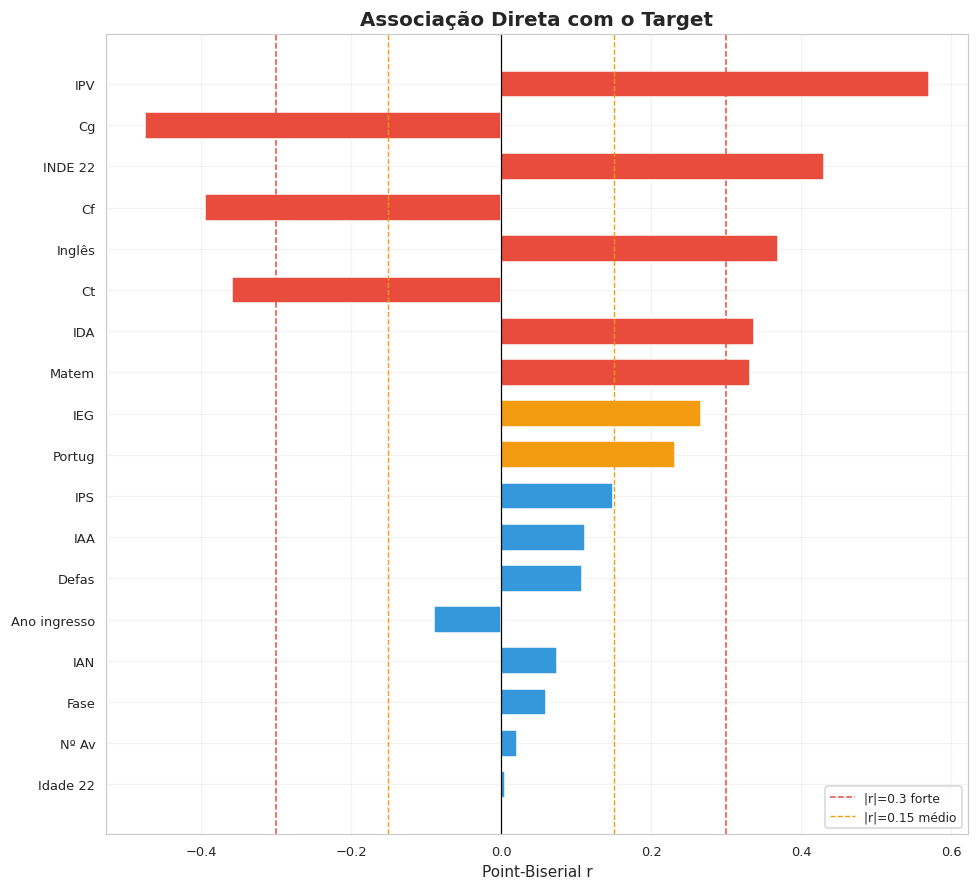

In [11]:
# ── 6b. ranking visual — |Point-Biserial r| ──────────
fig, ax = plt.subplots(figsize=(9, len(NUM)*0.4+1))

pb_vals = df_comp.set_index('Feature')['PB r']
order   = pb_vals.abs().sort_values().index
vals    = pb_vals.loc[order]

colors = ['#e74c3c' if abs(v)>0.3 else '#f39c12' if abs(v)>0.15 else '#3498db' for v in vals]
ax.barh(order, vals, color=colors, edgecolor='white', height=0.65)
ax.axvline(0, color='black', lw=0.8)
ax.axvline(0.3,  color='#e74c3c', ls='--', lw=1, label='|r|=0.3 forte')
ax.axvline(-0.3, color='#e74c3c', ls='--', lw=1)
ax.axvline(0.15,  color='#f39c12', ls='--', lw=0.9, label='|r|=0.15 médio')
ax.axvline(-0.15, color='#f39c12', ls='--', lw=0.9)
ax.set_xlabel('Point-Biserial r')
ax.set_title('Associação Direta com o Target', fontweight='bold')
ax.legend(loc='lower right', fontsize=8)
plt.tight_layout()
plt.show()


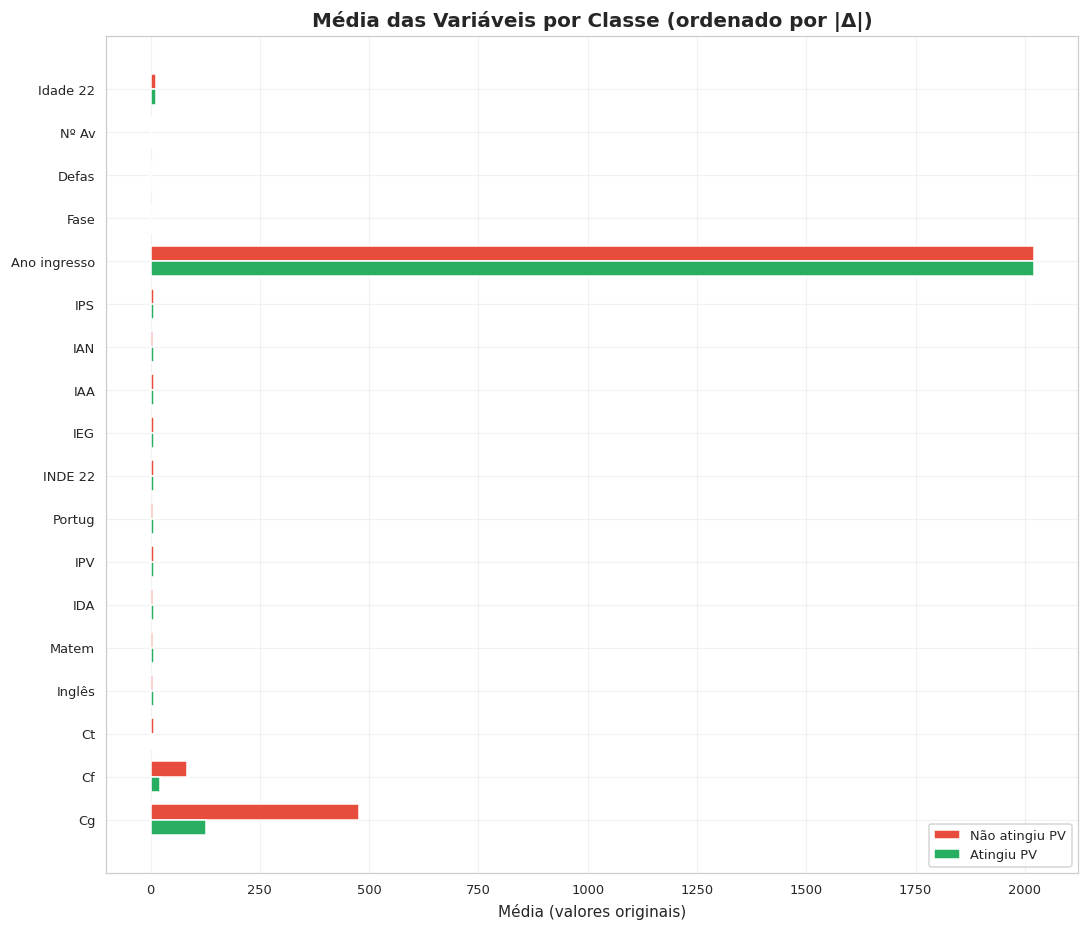

In [12]:
# ── 6c. médias por classe — barras horizontais ─────────
means_0 = [df.loc[df['_target'] == 0, c].mean() for c in NUM]
means_1 = [df.loc[df['_target'] == 1, c].mean() for c in NUM]
deltas  = [m1 - m0 for m0, m1 in zip(means_0, means_1)]

order_idx = sorted(range(len(NUM)), key=lambda i: abs(deltas[i]), reverse=True)
NUM_ord = [NUM[i] for i in order_idx]
m0_ord  = [means_0[i] for i in order_idx]
m1_ord  = [means_1[i] for i in order_idx]

y   = np.arange(len(NUM_ord))
h   = 0.36
fig, ax = plt.subplots(figsize=(10, len(NUM)*0.42 + 1))
ax.barh(y + h/2, m0_ord, h, color=PAL['0'], label='Não atingiu PV', edgecolor='white')
ax.barh(y - h/2, m1_ord, h, color=PAL['1'], label='Atingiu PV',     edgecolor='white')
ax.set_yticks(y)
ax.set_yticklabels(NUM_ord, fontsize=8.5)
ax.set_xlabel('Média (valores originais)')
ax.set_title('Média das Variáveis por Classe (ordenado por |Δ|)', fontweight='bold')
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()


## 7. Análise Bivariada — Correlações Pearson

Heatmap completo + identificação dos **pares mais correlacionados** (|r| > 0.25).
Correlações muito altas entre features (ex: INDE ↔ Cg, r = −0.96) indicam **multicolinearidade**
que pode impactar modelos lineares — a rede neural MagicStepsNet trata isso naturalmente.


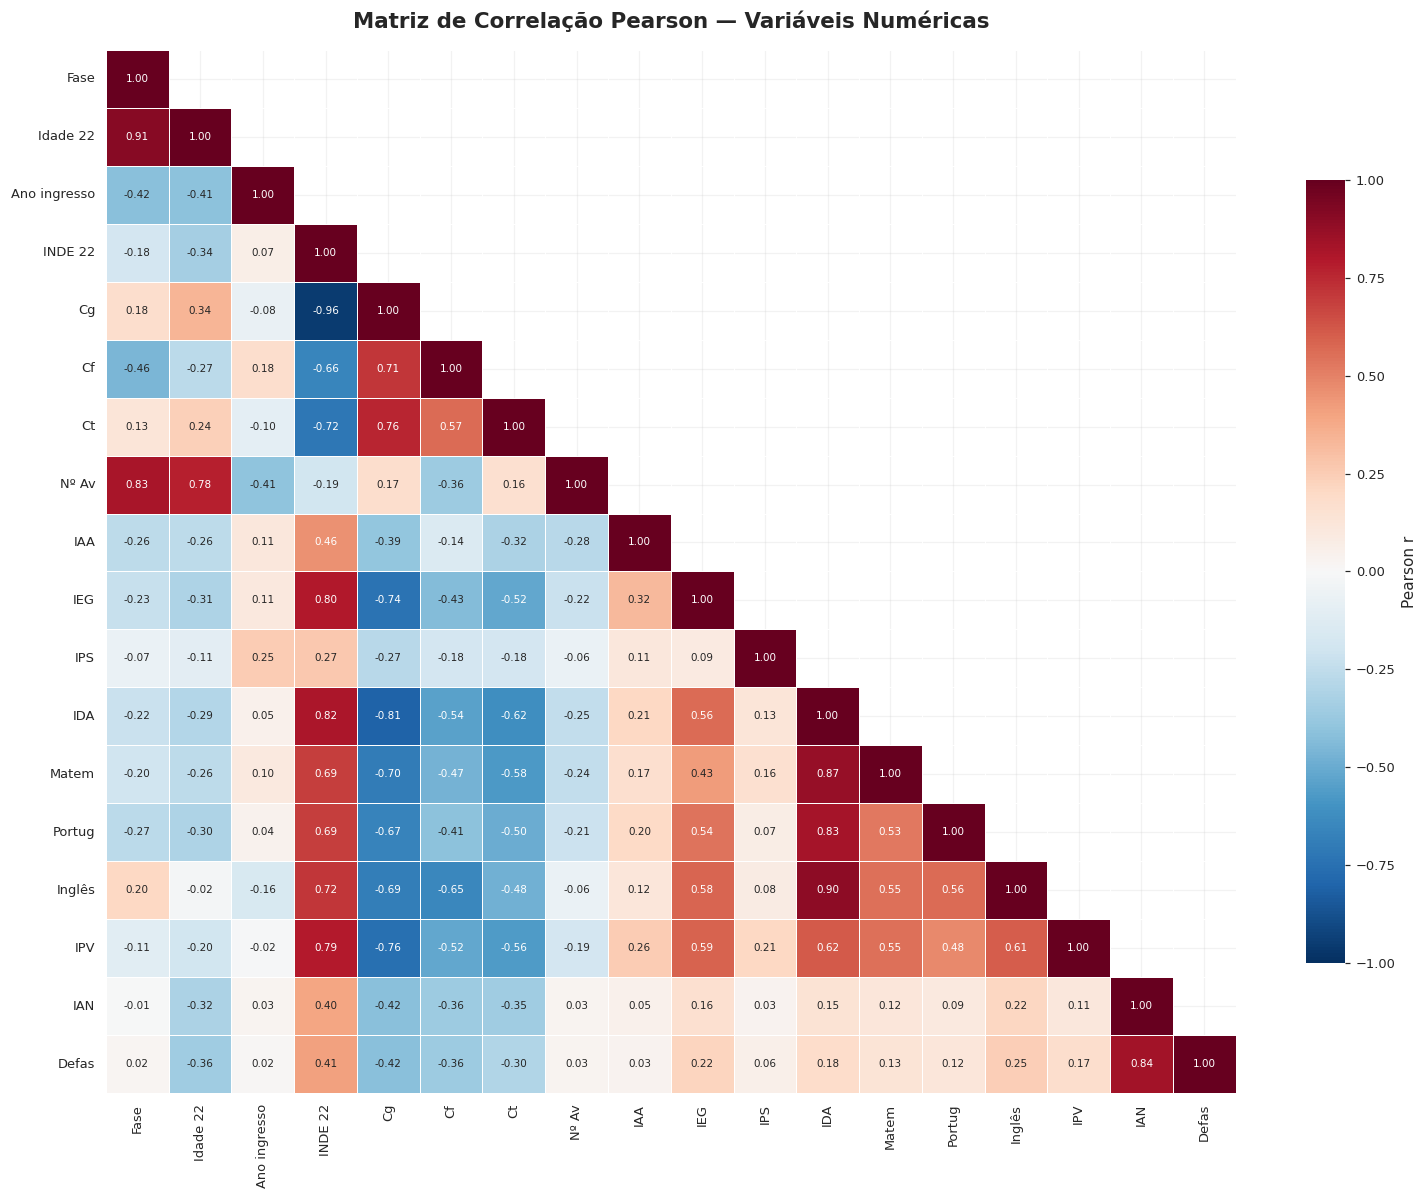

In [13]:
# ── 7a. heatmap ────────────────────────────────────────
corr = df[NUM].corr()
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

fig, ax = plt.subplots(figsize=(14, 11))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, vmin=-1, vmax=1, linewidths=0.5, linecolor='white',
            cbar_kws={'shrink':0.75, 'label':'Pearson r'},
            annot_kws={'size':6.8}, ax=ax)
ax.set_title('Matriz de Correlação Pearson — Variáveis Numéricas', fontsize=14, fontweight='bold', pad=14)
plt.tight_layout()
plt.show()


In [14]:
# ── 7b. pares com |r| > 0.25 — calculados ao vivo ─────
corr_matrix = df[NUM].corr()

pairs_live = []
for i in range(len(NUM)):
    for j in range(i + 1, len(NUM)):
        r = corr_matrix.iloc[i, j]
        if abs(r) > 0.25:
            pairs_live.append([NUM[i], NUM[j], round(r, 4)])

df_pairs = pd.DataFrame(pairs_live, columns=['Feature A','Feature B','Pearson r'])
df_pairs['|r|'] = df_pairs['Pearson r'].abs()
df_pairs['Interpretação'] = df_pairs['|r|'].apply(
    lambda x: '🔴 muito forte' if x > 0.7 else
              '🟠 forte'       if x > 0.5 else
              '🟡 moderada'    if x > 0.3 else
              '🔵 fraca')
df_pairs = df_pairs.sort_values('|r|', ascending=False).drop(columns='|r|')
df_pairs


,Feature A,Feature B,Pearson r,Interpretação
20,INDE 22,Cg,-0.9590,🔴 muito forte
0,Fase,Idade 22,0.9093,🔴 muito forte
74,IDA,Inglês,0.8961,🔴 muito forte
72,IDA,Matem,0.8693,🔴 muito forte
82,IAN,Defas,0.8384,🔴 muito forte
...,...,...,...,...
11,Idade 22,IAA,-0.2617,🔵 fraca
4,Fase,IAA,-0.2612,🔵 fraca
14,Idade 22,Matem,-0.2609,🔵 fraca
66,IAA,IPV,0.2556,🔵 fraca


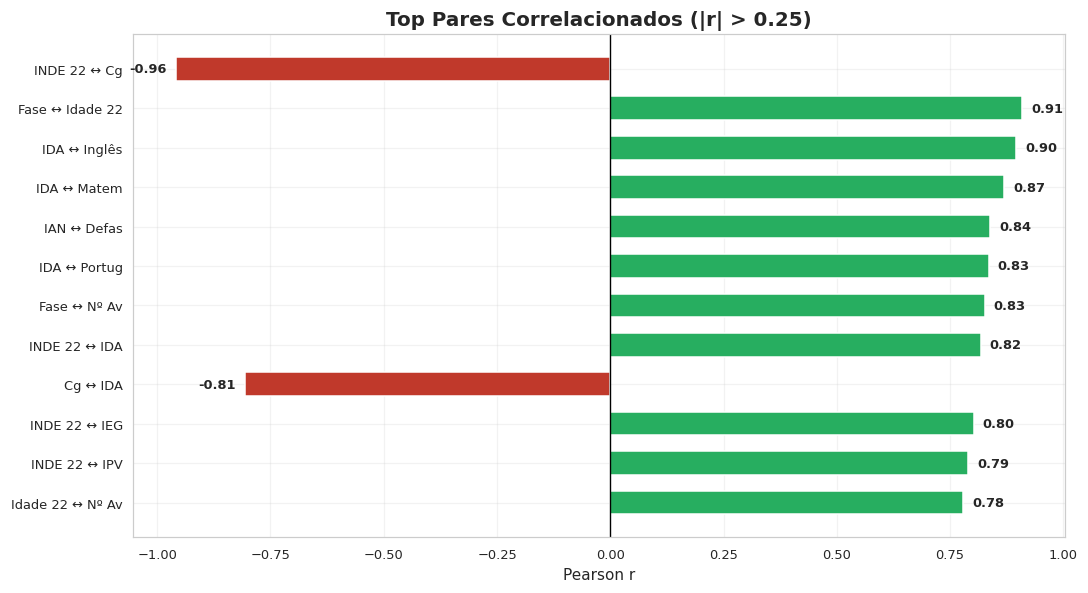

In [15]:
# ── 7c. top 10 pares — visualização ──────────────────
top = df_pairs.head(12).copy()
top['label'] = top['Feature A'] + ' ↔ ' + top['Feature B']

fig, ax = plt.subplots(figsize=(10, 5.5))
colors = ['#c0392b' if r<0 else '#27ae60' for r in top['Pearson r']]
bars = ax.barh(top['label'], top['Pearson r'], color=colors, edgecolor='white', height=0.6)
ax.axvline(0, color='black', lw=0.9)
for bar, val in zip(bars, top['Pearson r']):
    ax.text(val + (0.02 if val>0 else -0.02), bar.get_y()+bar.get_height()/2,
            f'{val:.2f}', va='center', ha='left' if val>0 else 'right',
            fontsize=8.5, fontweight='bold')
ax.set_xlabel('Pearson r')
ax.set_title('Top Pares Correlacionados (|r| > 0.25)', fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()


## 8. Variáveis Categóricas — Chi-Square & Cramér V

| Métrica | Interpretação |
|---|---|
| **χ² (Chi-Square)** | Testa independência entre variável categórica e target |
| **Cramér's V** | Effect size normalizado do χ². V > 0.1 pequeno, > 0.3 médio, > 0.5 grande |
| **p-valor** | < 0.05 → associação estatisticamente significativa |


In [16]:
# ── 8a. tabela chi-square — calculada ao vivo ──────────
from scipy import stats as _stats

rows_chi = []
for col in CAT:
    ct = pd.crosstab(df[col], df['_target'])
    chi2, p, dof, _ = _stats.chi2_contingency(ct)
    n = int(ct.sum().sum())
    k, q = ct.shape
    v = float(np.sqrt(chi2 / (n * (min(k, q) - 1)))) if min(k, q) > 1 else 0.0
    rows_chi.append([col, round(chi2, 4), round(p, 6), dof, round(v, 4)])

df_chi = pd.DataFrame(rows_chi,
    columns=['Variável','χ²','p-valor','gdl','Cramér V'])
df_chi['Sig.']      = df_chi['p-valor'].apply(lambda p: '✅ sim' if p < 0.05 else '❌ não')
df_chi['Força (V)'] = df_chi['Cramér V'].apply(
    lambda v: '🔴 grande' if v > 0.5 else '🟡 médio' if v > 0.3 else '🔵 pequeno')
df_chi = df_chi.sort_values('Cramér V', ascending=False)
df_chi


,Variável,χ²,p-valor,gdl,Cramér V,Sig.,Força (V)
2,Pedra 22,230.3394,0.000000,3,0.5175,✅ sim,🔴 grande
4,Rec Av1,133.7594,0.000000,5,0.3944,✅ sim,🟡 médio
1,Instituição de ensino,74.4524,0.000000,2,0.2942,✅ sim,🔵 pequeno
3,Turma,50.7426,0.000735,23,0.2429,✅ sim,🔵 pequeno
6,Fase ideal,15.1554,0.056193,8,0.1328,❌ não,🔵 pequeno
5,Rec Psicologia,10.5826,0.031678,4,0.1109,✅ sim,🔵 pequeno
0,Gênero,2.9230,0.087326,1,0.0583,❌ não,🔵 pequeno


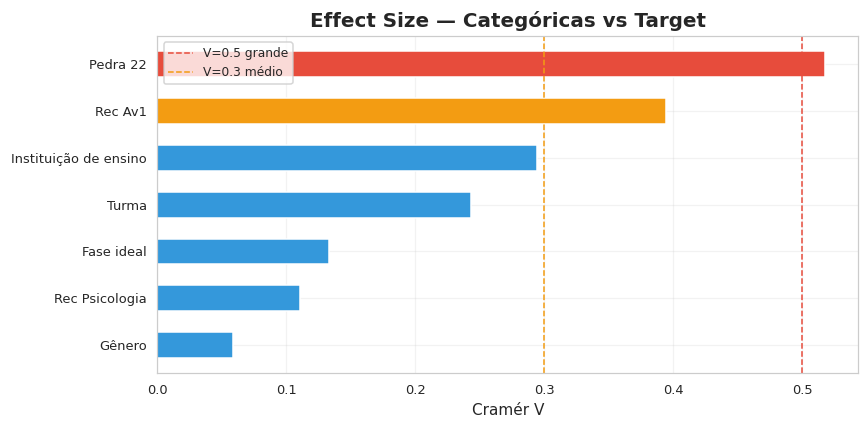

In [17]:
# ── 8b. Cramér V — ranking visual ────────────────────
fig, ax = plt.subplots(figsize=(8, 4))
chi_ord = df_chi.sort_values('Cramér V', ascending=True)
colors = ['#e74c3c' if v>0.5 else '#f39c12' if v>0.3 else '#3498db'
          for v in chi_ord['Cramér V']]
ax.barh(chi_ord['Variável'], chi_ord['Cramér V'], color=colors, edgecolor='white', height=0.55)
ax.axvline(0.5, color='#e74c3c', ls='--', lw=1, label='V=0.5 grande')
ax.axvline(0.3, color='#f39c12', ls='--', lw=1, label='V=0.3 médio')
ax.set_xlabel('Cramér V')
ax.set_title('Effect Size — Categóricas vs Target', fontweight='bold')
ax.legend(fontsize=8)
plt.tight_layout()
plt.show()


## 9. Taxa de Atingimento por Categoria

Para cada variável categórica, a taxa de `Atingiu PV = Sim` dentro de cada valor.
Isso revela **quais níveis da variável são mais predictivos** sem nenhum modelo.


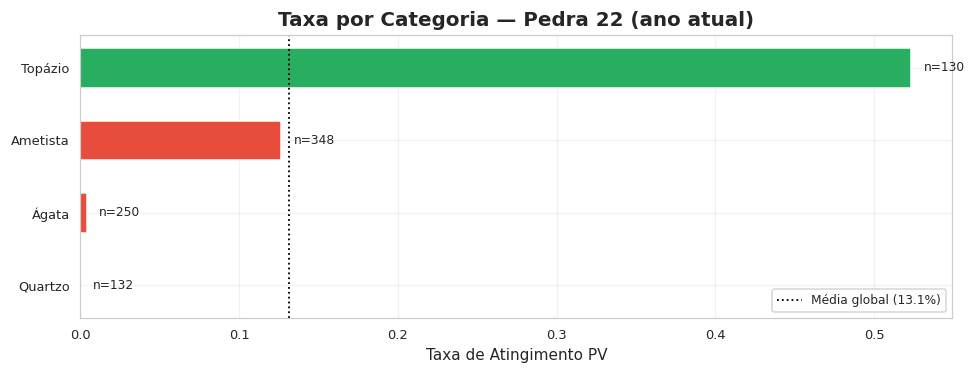

In [18]:
# ── Pedra 22 (ano atual) ──────────────────────────────────────────────
df_r = (df.groupby('Pedra 22')['_target']
        .agg(rate='mean', n='count')
        .reset_index()
        .sort_values('rate', ascending=False))
df_r['rate'] = df_r['rate'].round(4)

global_rate = df['_target'].mean()

fig, ax = plt.subplots(figsize=(9, max(3.5, len(df_r)*0.48 + 0.8)))
colors = ['#27ae60' if v > 0.3 else '#f39c12' if v > global_rate
          else '#e74c3c' for v in df_r['rate']]
bars = ax.barh(df_r['Pedra 22'].astype(str), df_r['rate'],
               color=colors, edgecolor='white', height=0.55)
ax.axvline(global_rate, color='black', ls=':', lw=1.2,
           label=f'Média global ({global_rate:.1%})')
for bar, n in zip(bars, df_r['n']):
    ax.text(bar.get_width() + 0.008, bar.get_y() + bar.get_height()/2,
            f'n={int(n)}', va='center', fontsize=8)
ax.set_xlabel('Taxa de Atingimento PV')
ax.set_title(f'Taxa por Categoria — Pedra 22 (ano atual)', fontweight='bold')
ax.legend(fontsize=8)
ax.invert_yaxis()
plt.tight_layout()
plt.show()


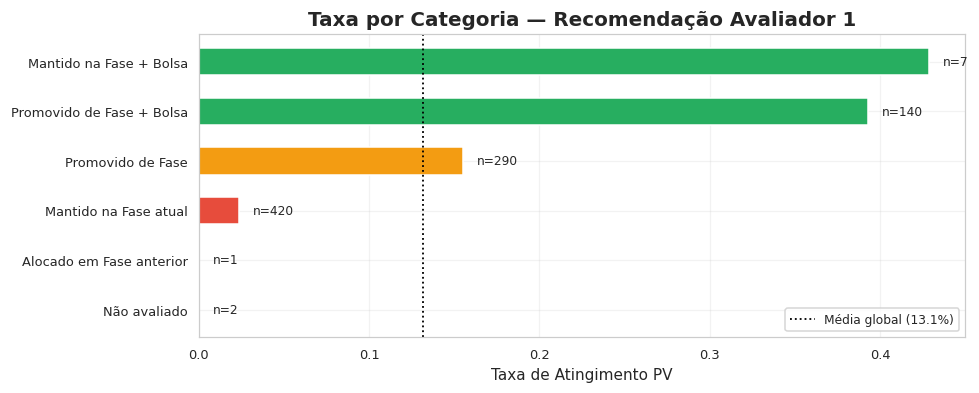

In [19]:
# ── Recomendação Avaliador 1 ──────────────────────────────────────────────
df_r = (df.groupby('Rec Av1')['_target']
        .agg(rate='mean', n='count')
        .reset_index()
        .sort_values('rate', ascending=False))
df_r['rate'] = df_r['rate'].round(4)

global_rate = df['_target'].mean()

fig, ax = plt.subplots(figsize=(9, max(3.5, len(df_r)*0.48 + 0.8)))
colors = ['#27ae60' if v > 0.3 else '#f39c12' if v > global_rate
          else '#e74c3c' for v in df_r['rate']]
bars = ax.barh(df_r['Rec Av1'].astype(str), df_r['rate'],
               color=colors, edgecolor='white', height=0.55)
ax.axvline(global_rate, color='black', ls=':', lw=1.2,
           label=f'Média global ({global_rate:.1%})')
for bar, n in zip(bars, df_r['n']):
    ax.text(bar.get_width() + 0.008, bar.get_y() + bar.get_height()/2,
            f'n={int(n)}', va='center', fontsize=8)
ax.set_xlabel('Taxa de Atingimento PV')
ax.set_title(f'Taxa por Categoria — Recomendação Avaliador 1', fontweight='bold')
ax.legend(fontsize=8)
ax.invert_yaxis()
plt.tight_layout()
plt.show()


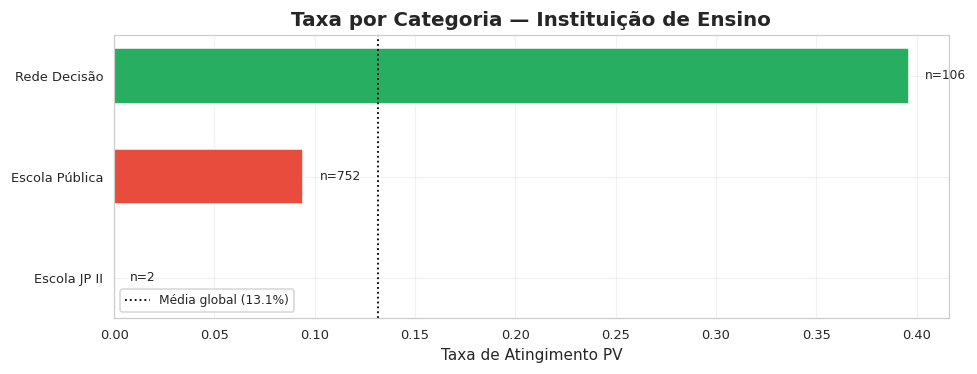

In [20]:
# ── Instituição de Ensino ──────────────────────────────────────────────
df_r = (df.groupby('Instituição de ensino')['_target']
        .agg(rate='mean', n='count')
        .reset_index()
        .sort_values('rate', ascending=False))
df_r['rate'] = df_r['rate'].round(4)

global_rate = df['_target'].mean()

fig, ax = plt.subplots(figsize=(9, max(3.5, len(df_r)*0.48 + 0.8)))
colors = ['#27ae60' if v > 0.3 else '#f39c12' if v > global_rate
          else '#e74c3c' for v in df_r['rate']]
bars = ax.barh(df_r['Instituição de ensino'].astype(str), df_r['rate'],
               color=colors, edgecolor='white', height=0.55)
ax.axvline(global_rate, color='black', ls=':', lw=1.2,
           label=f'Média global ({global_rate:.1%})')
for bar, n in zip(bars, df_r['n']):
    ax.text(bar.get_width() + 0.008, bar.get_y() + bar.get_height()/2,
            f'n={int(n)}', va='center', fontsize=8)
ax.set_xlabel('Taxa de Atingimento PV')
ax.set_title(f'Taxa por Categoria — Instituição de Ensino', fontweight='bold')
ax.legend(fontsize=8)
ax.invert_yaxis()
plt.tight_layout()
plt.show()


In [21]:
# ── Taxa por Gênero ──────────────────────────────────
df_r = (df.groupby('Gênero')['_target']
        .agg(taxa='mean', n='count')
        .reset_index()
        .sort_values('taxa', ascending=False))
df_r['taxa'] = (df_r['taxa'] * 100).round(2)
df_r.columns = ['Gênero', 'Taxa Atingiu PV (%)', 'n']
df_r


,Gênero,Taxa Atingiu PV (%),n
0,Menina,15.10,457
1,Menino,10.92,403


In [22]:
# ── Taxa por Turma ──────────────────────────────────
df_r = (df.groupby('Turma')['_target']
        .agg(taxa='mean', n='count')
        .reset_index()
        .sort_values('taxa', ascending=False))
df_r['taxa'] = (df_r['taxa'] * 100).round(2)
df_r.columns = ['Turma', 'Taxa Atingiu PV (%)', 'n']
df_r


,Turma,Taxa Atingiu PV (%),n
23,Z,33.33,9
0,A,28.97,107
18,S,28.57,7
14,O,25.00,12
22,Y,20.00,10
5,F,17.14,70
7,H,16.00,25
20,U,15.79,38
11,L,14.47,76
21,V,14.29,7


In [23]:
# ── Taxa por Rec Psicologia ──────────────────────────────────
df_r = (df.groupby('Rec Psicologia')['_target']
        .agg(taxa='mean', n='count')
        .reset_index()
        .sort_values('taxa', ascending=False))
df_r['taxa'] = (df_r['taxa'] * 100).round(2)
df_r.columns = ['Rec Psicologia', 'Taxa Atingiu PV (%)', 'n']
df_r


,Rec Psicologia,Taxa Atingiu PV (%),n
1,Não avaliado,20.00,5
4,Sem limitações,18.50,254
0,Não atendido,11.82,406
3,Requer avaliação,8.86,158
2,Não indicado,8.11,37


In [24]:
# ── Taxa por Fase ideal ──────────────────────────────────
df_r = (df.groupby('Fase ideal')['_target']
        .agg(taxa='mean', n='count')
        .reset_index()
        .sort_values('taxa', ascending=False))
df_r['taxa'] = (df_r['taxa'] * 100).round(2)
df_r.columns = ['Fase ideal', 'Taxa Atingiu PV (%)', 'n']
df_r


,Fase ideal,Taxa Atingiu PV (%),n
7,Fase 7 (3º EM),27.08,48
1,Fase 1 (4º ano),16.67,96
2,Fase 2 (5º e 6º ano),14.68,218
5,Fase 5 (1º EM),14.29,63
3,Fase 3 (7º e 8º ano),11.59,207
0,ALFA (2º e 3º ano),9.86,71
4,Fase 4 (9º ano),8.24,85
6,Fase 6 (2º EM),7.69,52
8,Fase 8 (Universitários),5.00,20


## 10. Evolução das Pedras (2020 → 2022)

A **Pedra** é o indicador principal de progresso do aluno dentro do programa.
Ordem crescente: Quartzo → Ágata → Topázio → Ametista.

Apenas **323 alunos** possuem dados nas três edições. Os demais entraram depois de 2020.


In [25]:
# ── 10a. resumo transições — calculado ao vivo ─────────
PEDRA_ORDER = {'Quartzo': 0, 'Ágata': 1, 'Topázio': 2, 'Ametista': 3}

mask3 = df[['Pedra 20','Pedra 21','Pedra 22']].notna().all(axis=1)
sub   = df.loc[mask3].copy()
sub['p20'] = sub['Pedra 20'].map(PEDRA_ORDER)
sub['p21'] = sub['Pedra 21'].map(PEDRA_ORDER)
sub['p22'] = sub['Pedra 22'].map(PEDRA_ORDER)

n_total      = len(sub)
n_prom_20_21 = int((sub['p21'] > sub['p20']).sum())
n_prom_21_22 = int((sub['p22'] > sub['p21']).sum())
n_regress    = int(((sub['p21'] < sub['p20']) | (sub['p22'] < sub['p21'])).sum())
n_prom_both  = int(((sub['p21'] > sub['p20']) & (sub['p22'] > sub['p21'])).sum())

resumo = pd.DataFrame({
    'Métrica': ['Alunos com Pedra nos 3 anos',
                'Promovidos 2020→2021',
                'Promovidos 2021→2022',
                'Regressaram (algum período)',
                'Promovidos nos dois períodos'],
    'Valor':   [n_total, n_prom_20_21, n_prom_21_22, n_regress, n_prom_both],
})
resumo


,Métrica,Valor
0,Alunos com Pedra nos 3 anos,323
1,Promovidos 2020→2021,53
2,Promovidos 2021→2022,59
3,Regressaram (algum período),196
4,Promovidos nos dois períodos,2


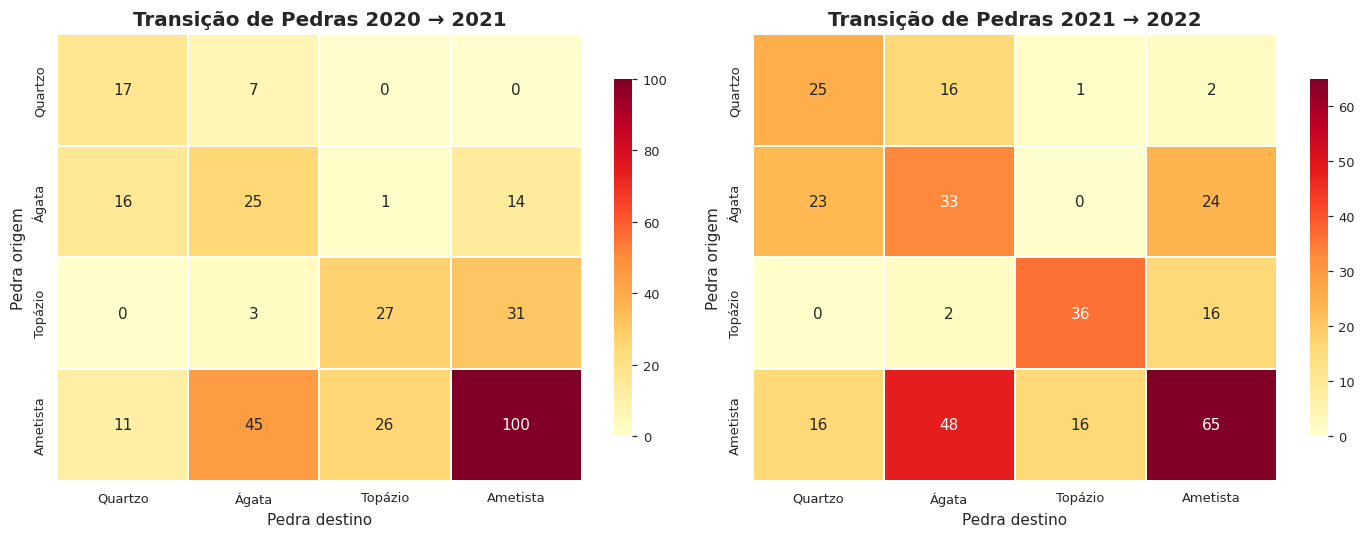

In [26]:
# ── 10b. transições Pedra — heatmap ──────────────────
ORDER = {'Quartzo':0,'Ágata':1,'Topázio':2,'Ametista':3}
mask3 = df[['Pedra 20','Pedra 21','Pedra 22']].notna().all(axis=1)
sub   = df.loc[mask3].copy()

# 20 → 21
ct_a = pd.crosstab(sub['Pedra 20'], sub['Pedra 21'])
# 21 → 22
ct_b = pd.crosstab(sub['Pedra 21'], sub['Pedra 22'])

order_labels = ['Quartzo','Ágata','Topázio','Ametista']
ct_a = ct_a.reindex(index=order_labels, columns=order_labels, fill_value=0)
ct_b = ct_b.reindex(index=order_labels, columns=order_labels, fill_value=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

for ax, ct, title in [(ax1, ct_a, '2020 → 2021'), (ax2, ct_b, '2021 → 2022')]:
    sns.heatmap(ct, annot=True, fmt='d', cmap='YlOrRd', ax=ax,
                linewidths=1, linecolor='white', cbar_kws={'shrink':0.8})
    ax.set_title(f'Transição de Pedras {title}', fontweight='bold')
    ax.set_xlabel('Pedra destino')
    ax.set_ylabel('Pedra origem')

plt.tight_layout()
plt.show()


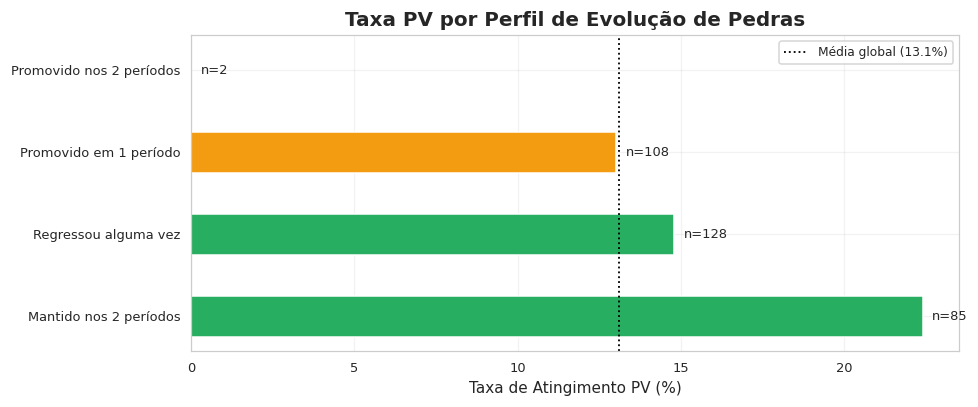

In [27]:
# ── 10c. taxa de atingimento PV por perfil de transição
ORDER = {'Quartzo':0,'Ágata':1,'Topázio':2,'Ametista':3}
mask3 = df[['Pedra 20','Pedra 21','Pedra 22']].notna().all(axis=1)
sub   = df.loc[mask3].copy()
sub['p20'] = sub['Pedra 20'].map(ORDER)
sub['p21'] = sub['Pedra 21'].map(ORDER)
sub['p22'] = sub['Pedra 22'].map(ORDER)
sub['perfil'] = (
    np.where((sub['p21']>sub['p20'])&(sub['p22']>sub['p21']), 'Promovido nos 2 períodos',
    np.where((sub['p21']>sub['p20'])|(sub['p22']>sub['p21']), 'Promovido em 1 período',
    np.where((sub['p21']<sub['p20'])|(sub['p22']<sub['p21']), 'Regressou alguma vez',
    'Mantido nos 2 períodos')))
)
taxa = (sub.groupby('perfil')['_target']
        .agg(['mean','count'])
        .rename(columns={'mean':'Taxa PV','count':'n'})
        .sort_values('Taxa PV', ascending=False))
taxa['Taxa PV'] = (taxa['Taxa PV']*100).round(1)

fig, ax = plt.subplots(figsize=(9, 3.8))
colors = ['#27ae60' if v>13 else '#f39c12' if v>8 else '#e74c3c' for v in taxa['Taxa PV']]
bars = ax.barh(taxa.index, taxa['Taxa PV'], color=colors, edgecolor='white', height=0.5)
ax.axvline(13.1, color='black', ls=':', lw=1.2, label='Média global (13.1%)')
for bar, n in zip(bars, taxa['n']):
    ax.text(bar.get_width()+0.3, bar.get_y()+bar.get_height()/2,
            f'n={n}', va='center', fontsize=8.5)
ax.set_xlabel('Taxa de Atingimento PV (%)')
ax.set_title('Taxa PV por Perfil de Evolução de Pedras', fontweight='bold')
ax.legend(fontsize=8)
plt.tight_layout()
plt.show()


## 11. Dados Ausentes — Padrões & Impacto

Variáveis com missingness > 5 % precisam de tratamento explícito no pipeline.


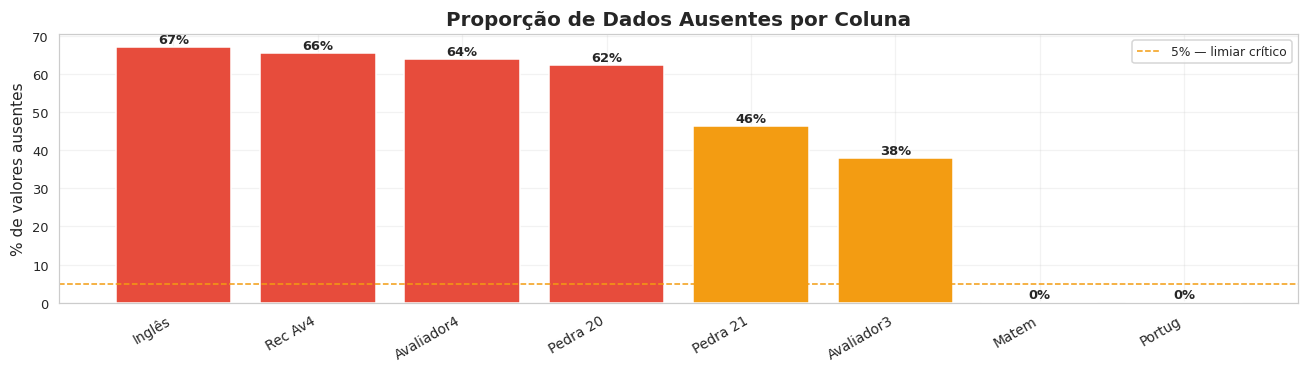

In [28]:
# ── 11a. heatmap missingness ──────────────────────────
cols_miss = df.columns[df.isna().any()].tolist()

fig, ax = plt.subplots(figsize=(12, 3.5))
miss_pct = df[cols_miss].isna().mean()*100
miss_ord = miss_pct.sort_values(ascending=False)

colors = ['#e74c3c' if v>50 else '#f39c12' if v>10 else '#3498db' for v in miss_ord]
bars = ax.bar(range(len(miss_ord)), miss_ord.values, color=colors, edgecolor='white')
ax.set_xticks(range(len(miss_ord)))
ax.set_xticklabels(miss_ord.index, rotation=30, ha='right', fontsize=9)
for bar, v in zip(bars, miss_ord.values):
    ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+1,
            f'{v:.0f}%', ha='center', fontsize=8.5, fontweight='bold')
ax.axhline(5, color='#f39c12', ls='--', lw=1, label='5% — limiar crítico')
ax.set_ylabel('% de valores ausentes')
ax.set_title('Proporção de Dados Ausentes por Coluna', fontweight='bold')
ax.legend(fontsize=8)
plt.tight_layout()
plt.show()


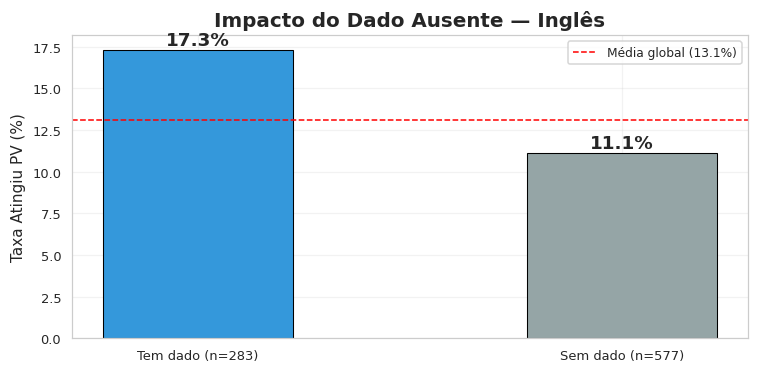


📌 Alunos COM nota Inglês  → taxa PV = 17.3%
📌 Alunos SEM nota Inglês → taxa PV = 11.1%
📌 O dado ausente é NÃO-ALEATÓRIO: quem não tem a nota tem taxa PV muito mais alta.


In [29]:
# ── 11b. impacto do missing no target ─────────────────
# para Inglês (67% nulos) — compara taxa PV entre quem tem e não tem
has_ing  = df['Inglês'].notna()
rate_has = df.loc[has_ing,  '_target'].mean()
rate_no  = df.loc[~has_ing, '_target'].mean()

fig, ax = plt.subplots(figsize=(7, 3.5))
labels = [f'Tem dado (n={has_ing.sum()})', f'Sem dado (n={(~has_ing).sum()})']
ax.bar(labels, [rate_has*100, rate_no*100], color=['#3498db','#95a5a6'],
       edgecolor='black', linewidth=0.7, width=0.45)
ax.axhline(13.1, color='red', ls='--', lw=1, label='Média global (13.1%)')
for i, v in enumerate([rate_has*100, rate_no*100]):
    ax.text(i, v+0.3, f'{v:.1f}%', ha='center', fontsize=12, fontweight='bold')
ax.set_ylabel('Taxa Atingiu PV (%)')
ax.set_title('Impacto do Dado Ausente — Inglês', fontweight='bold')
ax.legend(fontsize=8)
plt.tight_layout()
plt.show()

print(f'\n📌 Alunos COM nota Inglês  → taxa PV = {rate_has:.1%}')
print(f'📌 Alunos SEM nota Inglês → taxa PV = {rate_no:.1%}')
print(f'📌 O dado ausente é NÃO-ALEATÓRIO: quem não tem a nota tem taxa PV muito mais alta.')


## 12. Conclusões & Recomendações para o Pipeline

### 🔍 Achados Principais

| # | Achado | Evidência |
|---|--------|-----------|
| 1 | **IPV é o predictor mais forte** | Point-Biserial r = +0.57, Mann-Whitney p < 0.001, rank-biserial = 0.99 |
| 2 | **Cg (caderneta global) é inversamente correlado** | r = −0.47 com o target. Valores baixos de Cg → maior chance de atingir PV |
| 3 | **Pedra 22 é a variável categórica mais informativa** | Cramér V = 0.52 (grande). Topázio → 52% de taxa PV; Quartzo → 0% |
| 4 | **Multicolinearidade severa** | INDE ↔ Cg (r = −0.96), IDA ↔ Inglês (r = 0.90). O pipeline removeu notas individuais corretamente |
| 5 | **Desbalanceamento 6.6:1** | Justifica oversampling sintético aplicado no preprocessing |
| 6 | **Inglês tem missing não-aleatório (MNAR)** | 67% nulos, mas quem não tem a nota tem taxa PV 3× maior. Indica que missingness é informativo |
| 7 | **Todas as distribuições rejeitam normalidade** | Shapiro-Wilk p < 0.001 em todas. Mann-Whitney é o teste apropriado |

### 🎯 Recomendações para o Pipeline

| Prioridade | Ação |
|:---:|---|
| 🔴 | Manter **IPV, INDE, IEG, IDA** como features centrais — são os maiores predictores |
| 🔴 | Usar **Pedra 22** como feature categórica (já feito via `pedra_modal`) |
| 🟡 | Considerar uma feature binária **`missing_ingles`** — o próprio missingness é informativo |
| 🟡 | Validar que o oversampling não introduce correlações artificiais entre as features engineered |
| 🟢 | Features como `Idade 22` e `Nº Av` mostraram associação fraca — considerar remoção para reduzir ruído |
